<a href="https://www.kaggle.com/erfansobhaei/persainpoemclassifier?scriptVersionId=86060153" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Installing and Importing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import wandb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import TrainingArguments, Trainer

In [2]:
!pip install wandb --upgrade

     |████████████████████████████████| 1.7 MB 4.3 MB/s            
  Attempting uninstall: wandb
    Found existing installation: wandb 0.12.7
    Uninstalling wandb-0.12.7:
      Successfully uninstalled wandb-0.12.7


In [3]:
!pip install -q gdown
!gdown --id --folder 1cmrCgvpowRN4ySol4J8ZT0oVh_0v75Q_

Retrieving folder list
Retrieving folder 1BofFHgAzps0hcdbKnR6vNmj7_hlw0cKU org
Processing file 1XmfqB3ZPw8W6jicmHVtkPRekf9ze2snR poetry_rumi.txt
Processing file 11mlHdcZZJTjGcPvB7hio91D_OjB0MQRc poetry_saadi.txt
Retrieving folder 1dOatmQ0CrMEN4lmWl9Pt7v7Ts0dm7W6p small
Processing file 1nXY_40w8GHVx3ujfjBPNYFChww7Jhcvm poetry_rumi.txt
Processing file 1K-IzTHCR5u_EUm_ZXSrdR6a02qLLD-hg poetry_saadi.txt
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1XmfqB3ZPw8W6jicmHVtkPRekf9ze2snR
To: /kaggle/working/dataset/org/poetry_rumi.txt
100%|████████████████████████████████████████| 194k/194k [00:00<00:00, 81.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=11mlHdcZZJTjGcPvB7hio91D_OjB0MQRc
To: /kaggle/working/dataset/org/poetry_saadi.txt
100%|████████████████████████████████████████| 110k/110k [00:00<00:00, 72.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nXY_40w8GHVx

# Small Dataset Classification

## Understanding Dataset 

In [4]:
def read_file(path, label):
    df = pd.read_csv(path, delimiter = "\n", names=["text", 'label'])
    df['label'] = label
    return df

In [5]:
df_rumi_small = read_file('./dataset/small/poetry_rumi.txt', 'Rumi')
df_saadi_small = read_file('./dataset/small/poetry_saadi.txt', 'Saadi')

df_small = pd.concat([df_rumi_small, df_saadi_small], ignore_index=True)
df = df_small.sample(frac=1).reset_index(drop=True)
df.head()

,text,label
0,بد ز گستاخی کسوف آفتاب,Rumi
1,بیا که وقت بهارست تا من و تو به هم,Saadi
2,بحر تلخ و بحر شیرین در جهان,Rumi
3,دامن او گیر زوتر بی‌گمان,Rumi
4,از دل من تا دل تو روزنست,Rumi


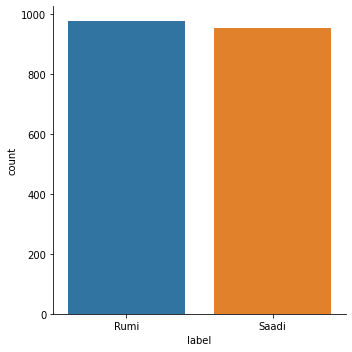

In [6]:
sns.catplot(data=df, x='label', kind='count')
plt.show()

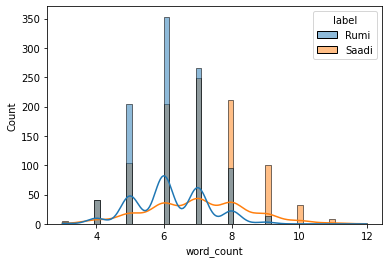

In [7]:
df['word_count'] = df['text'].str.count(' ') + 1

sns.histplot(data=df, x='word_count', hue='label', kde=True)
plt.show()

# Using Transformer Models

## BERT

### Loading Pretrained Model

In [8]:
from transformers import BertForSequenceClassification, BertTokenizer

In [9]:
model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

### Preprocess Data

In [10]:
df['label'] = pd.factorize(df['label'])[0]

X = list(df['text'])
y = list(df['label'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, label=None):
        self.encodings = encodings
        self.label = label

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.label:
            item["label"] = torch.tensor(self.label[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

### Train Model

In [12]:
def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=preds)
    f1 = f1_score(y_true=labels, y_pred=preds)

    return {"accuracy":accuracy, "f1": f1}

In [13]:
args = TrainingArguments(
    output_dir="output/bert",
    run_name="BERT Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    num_train_epochs=10,
    logging_steps = 10,
    seed=0,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
wandb.finish()

***** Running training *****
  Num examples = 1544
  Num Epochs = 10
  Instantaneous batch size per device = 100
  Total train batch size (w. parallel, distributed & accumulation) = 100
  Gradient Accumulation steps = 1
  Total optimization steps = 160
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.639300,0.647287,0.707254,0.611684
2,0.466900,0.487870,0.766839,0.785714
3,0.344500,0.446557,0.821244,0.792793
4,0.185700,0.383215,0.865285,0.858696
5,0.155300,0.458534,0.847150,0.833803
6,0.095500,0.621097,0.829016,0.841346
7,0.072200,0.493064,0.865285,0.865979
8,0.062400,0.580877,0.867876,0.868217
9,0.050300,0.590758,0.873057,0.870027
10,0.041000,0.591775,0.860104,0.854839


***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100


Training completed. Do not forget to share your model on huggingface.co/models =)




eval/accuracy,▁▄▆█▇▆███▇
eval/f1,▁▆▆█▇▇████
eval/loss,█▄▃▁▃▇▄▆▇▇
eval/runtime,▃▁▅▃█▃▃▃▃▅
eval/samples_per_second,▆█▄▆▁▆▆▅▆▄
eval/steps_per_second,▆█▄▆▁▆▆▅▆▄
train/epoch,▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇████
train/global_step,▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇████
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/loss,█▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁
train/total_flos,▁


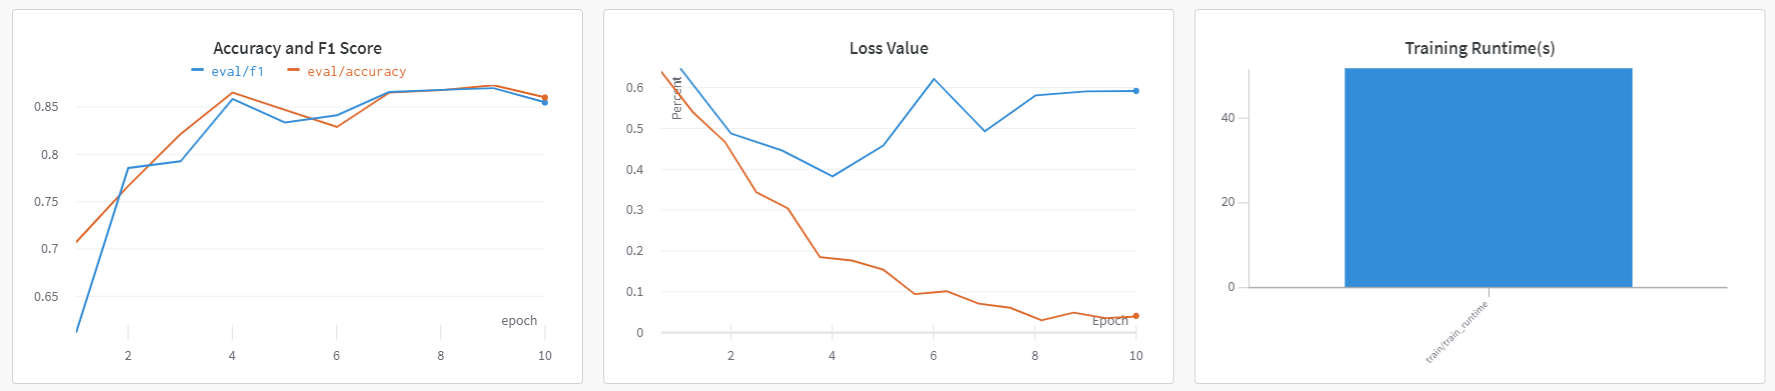

## XLMRoBERTa

### Loading Pretrained Model

In [14]:
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer

In [15]:
model_name = "xlm-roberta-base"
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp4666ert9


Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

storing https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model in cache at /root/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8
creating metadata file for /root/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8
https://huggingface.co/xlm-roberta-base/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp8g1g4npu


Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

storing https://huggingface.co/xlm-roberta-base/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/daeda8d936162ca65fe6dd158ecce1d8cb56c17d89b78ab86be1558eaef1d76a.a984cf52fc87644bd4a2165f1e07e0ac880272c1e82d648b4674907056912bd7
creating metadata file for /root/.cache/huggingface/transformers/daeda8d936162ca65fe6dd158ecce1d8cb56c17d89b78ab86be1558eaef1d76a.a984cf52fc87644bd4a2165f1e07e0ac880272c1e82d648b4674907056912bd7
loading file https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model from cache at /root/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8
loading file https://huggingface.co/xlm-roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

storing https://huggingface.co/xlm-roberta-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.ab95cf27f9419a99cce4f19d09e655aba382a2bafe2fe26d0cc24c18cf1a1af6
creating metadata file for /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.ab95cf27f9419a99cce4f19d09e655aba382a2bafe2fe26d0cc24c18cf1a1af6
loading configuration file https://huggingface.co/xlm-roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.ab95cf27f9419a99cce4f19d09e655aba382a2bafe2fe26d0cc24c18cf1a1af6
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "in

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

storing https://huggingface.co/xlm-roberta-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2
creating metadata file for /root/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2
loading weights file https://huggingface.co/xlm-roberta-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias',

### Preprocess Data

In [16]:
X = list(df['text'])
y = list(df['label'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=128)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=128)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [17]:
args = TrainingArguments(
    output_dir="output/xlmroberta",
    run_name="XLMRoBERTa Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    logging_steps =10,
    seed=0,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
wandb.finish()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1544
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 490
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: erfansobhaei (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.616000,0.595067,0.676166,0.725275
2,0.497500,1.245442,0.603627,0.708571
3,0.403200,0.452094,0.800518,0.818824
4,0.251500,0.811514,0.792746,0.816514
5,0.250200,0.420845,0.867876,0.869565
6,0.185300,0.639316,0.823834,0.838095
7,0.102100,0.562120,0.880829,0.872928
8,0.054900,0.766897,0.870466,0.875000
9,0.064800,0.798011,0.870466,0.872449
10,0.050500,0.782958,0.878238,0.878553


***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




eval/accuracy,▃▁▆▆█▇████
eval/f1,▂▁▆▅█▆████
eval/loss,▂█▁▄▁▃▂▄▄▄
eval/runtime,▂▁▁▁▂▁▁▁█▂
eval/samples_per_second,▇███▇███▁▇
eval/steps_per_second,▇███▇███▁▇
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,███▇▇█▇▆▆▆▅▅▄▄▄▃▃▄▃▃▂▂▂▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
train/total_flos,▁


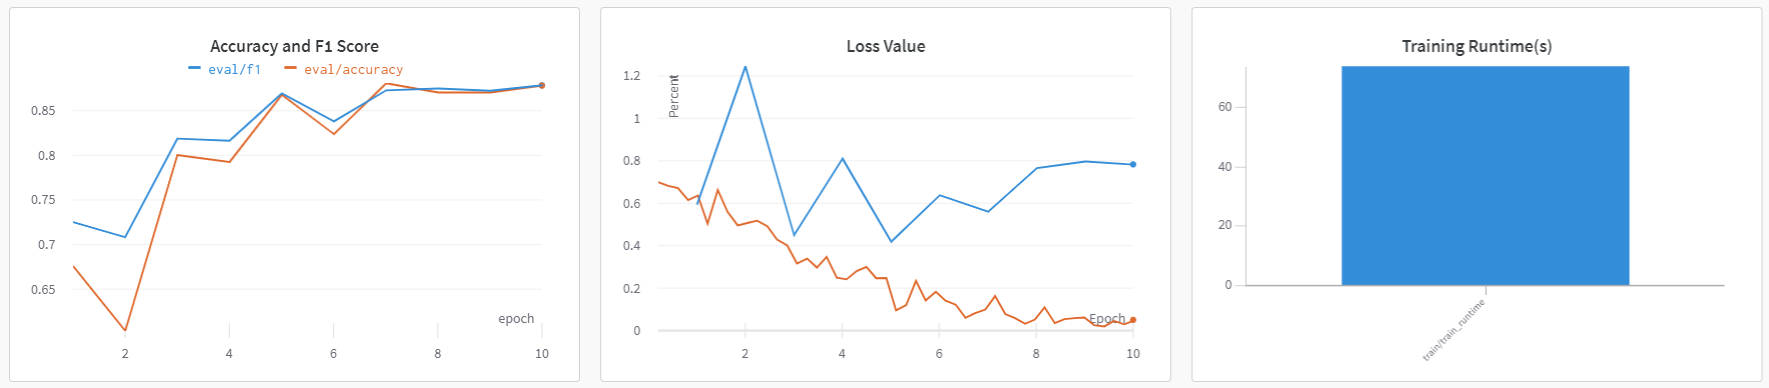

## DistrilBERT

### Loading Pretrained Model

In [18]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer 

In [19]:
model_name = "distilbert-base-multilingual-cased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp1dl59nlq


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/28e5b750bf4f39cc620367720e105de1501cf36ec4ca7029eba82c1d2cc47caf.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
creating metadata file for /root/.cache/huggingface/transformers/28e5b750bf4f39cc620367720e105de1501cf36ec4ca7029eba82c1d2cc47caf.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpkw0n10ww


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/47087d99feeb3bc6184d7576ff089c52f7fbe3219fe48c6c4fa681e617753256.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
creating metadata file for /root/.cache/huggingface/transformers/47087d99feeb3bc6184d7576ff089c52f7fbe3219fe48c6c4fa681e617753256.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpz0ry9u5k


Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/5cbdf121f196be5f1016cb102b197b0c34009e1e658f513515f2eebef9f38093.b33e51591f94f17c238ee9b1fac75b96ff2678cbaed6e108feadb3449d18dc24
creating metadata file for /root/.cache/huggingface/transformers/5cbdf121f196be5f1016cb102b197b0c34009e1e658f513515f2eebef9f38093.b33e51591f94f17c238ee9b1fac75b96ff2678cbaed6e108feadb3449d18dc24
loading file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/28e5b750bf4f39cc620367720e105de1501cf36ec4ca7029eba82c1d2cc47caf.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
loading file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/special_tokens_map.json from cache at None
loading

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/cf37a9dc282a679f121734d06f003625d14cfdaf55c14358c4c0b8e7e2b89ac9.7a727bd85e40715bec919a39cdd6f0aba27a8cd488f2d4e0f512448dcd02bf0f
creating metadata file for /root/.cache/huggingface/transformers/cf37a9dc282a679f121734d06f003625d14cfdaf55c14358c4c0b8e7e2b89ac9.7a727bd85e40715bec919a39cdd6f0aba27a8cd488f2d4e0f512448dcd02bf0f
loading configuration file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/cf37a9dc282a679f121734d06f003625d14cfdaf55c14358c4c0b8e7e2b89ac9.7a727bd85e40715bec919a39cdd6f0aba27a8cd488f2d4e0f512448dcd02bf0f
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embed

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/7b48683e2e7ba71cd1d7d6551ac325eceee01db5c2f3e81cfbfd1ee7bb7877f2.c24097b0cf91dbc66977325325fd03112f0f13d0e3579abbffc8d1e45f8d0619
creating metadata file for /root/.cache/huggingface/transformers/7b48683e2e7ba71cd1d7d6551ac325eceee01db5c2f3e81cfbfd1ee7bb7877f2.c24097b0cf91dbc66977325325fd03112f0f13d0e3579abbffc8d1e45f8d0619
loading weights file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/7b48683e2e7ba71cd1d7d6551ac325eceee01db5c2f3e81cfbfd1ee7bb7877f2.c24097b0cf91dbc66977325325fd03112f0f13d0e3579abbffc8d1e45f8d0619
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projec

In [20]:
X = list(df['text'])
y = list(df['label'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [21]:
args = TrainingArguments(
    output_dir="output/distilbert",
    run_name="DistilBERT Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    num_train_epochs=10,
    logging_steps =10,
    seed=0,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
wandb.finish()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1544
  Num Epochs = 10
  Instantaneous batch size per device = 100
  Total train batch size (w. parallel, distributed & accumulation) = 100
  Gradient Accumulation steps = 1
  Total optimization steps = 160
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.655900,0.482466,0.787565,0.761628
2,0.398900,0.408332,0.818653,0.777070
3,0.335200,0.406326,0.852332,0.858561
4,0.197400,0.316945,0.883420,0.877384
5,0.179300,0.440218,0.867876,0.874074
6,0.111300,0.308478,0.896373,0.893048
7,0.055200,0.358705,0.901554,0.900000
8,0.045500,0.375769,0.904145,0.899729
9,0.023100,0.394230,0.906736,0.902703
10,0.024000,0.405667,0.909326,0.908136


***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100


Training completed. Do not forget to share your model on huggingface.co/models =)




eval/accuracy,▁▃▅▇▆▇████
eval/f1,▁▂▆▇▆▇████
eval/loss,█▅▅▁▆▁▃▄▄▅
eval/runtime,▇▄▄▃▁▃▃█▂▄
eval/samples_per_second,▂▅▅▆█▆▆▁▇▅
eval/steps_per_second,▂▅▅▆█▆▆▁▇▅
train/epoch,▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇████
train/global_step,▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇████
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/loss,█▆▅▄▄▃▂▃▂▂▁▁▁▁▁▁
train/total_flos,▁


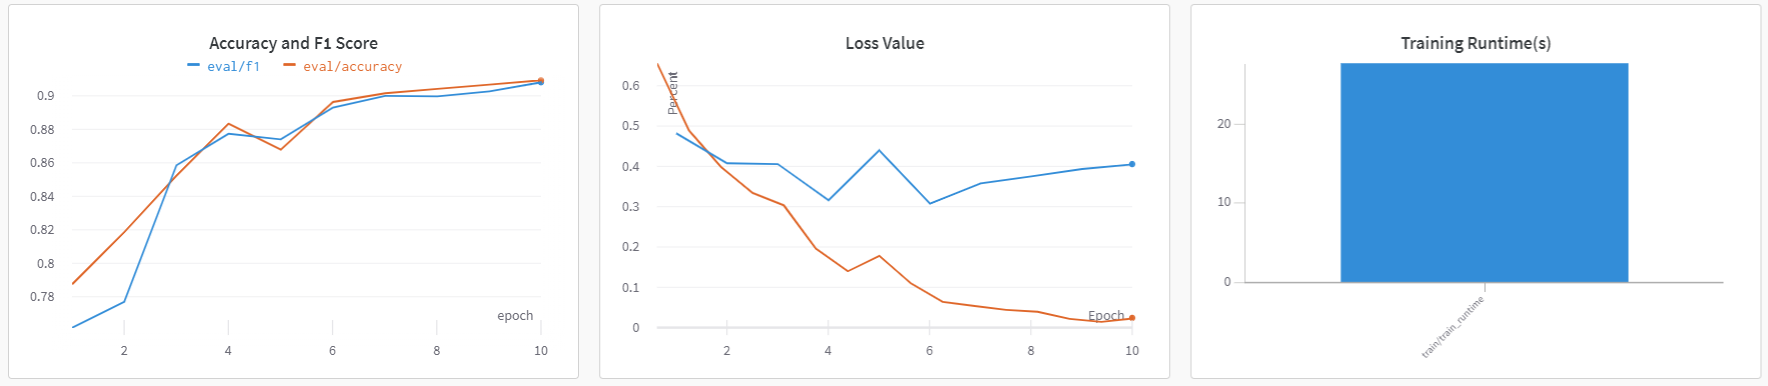